### ライブラリのimport

In [49]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
%matplotlib inline
from preprocessing.initial_preprocessing import initial_preprocessing
from preprocessing.drop_emergency_suspicious_height_weight import drop_emergency_suspicious_height_weight
from preprocessing.calculate_bmi_bmr_category import calculate_bmi_bmr_category
from preprocessing.remove_duplicate_ctdi import remove_duplicate_ctdi
from permutation_feature_importance.PermutationFeatureImportance import PermutationFeatureImportance 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 解析用の元データを読み込み

In [12]:
df = pd.read_excel('train_data.xlsx')

## データを前処理
* カラム名の変更
* 複数回スキャンについては,Mean CTDIvolが最大のみ残す
* 救急科などの怪しい身長と体重のデータを削除する

In [7]:
initial_preprocessing(df)
df = remove_duplicate_ctdi(df)
df.reset_index(drop=True, inplace=True)
# df_allで後で、身長体重を代入する分を分けられるようにしておく
df_all = df
df = drop_emergency_suspicious_height_weight(df)

正常に処理が行われました。


### 身長・体重の最終確認: この部分は自分で確認しないと危険

In [8]:
df['height_cm'].sort_values()

1200    101.0
97      101.0
2241    101.0
2362    101.0
1011    101.0
        ...  
8610    190.9
7978    190.9
790     193.0
8       193.0
5567    193.0
Name: height_cm, Length: 8958, dtype: float64

In [9]:
index = df['height_cm'].sort_values(ascending=True)[:30].index.to_list()

In [10]:
df[['scanning length', 'height_cm', 'weight_kg', 'id', 'study_date', 'target region', 'Mean CTDIvol']].loc[index]

,scanning length,height_cm,weight_kg,id,study_date,target region,Mean CTDIvol
1200,796.77,101.0,39.80,75206,2021-06-18,Chest,6.70
97,626.53,101.0,39.80,75206,2021-01-14,Abdomen,12.78
2241,852.06,101.0,39.80,75206,2021-04-21,Chest,6.45
2362,621.51,101.0,39.80,75206,2021-06-02,Abdomen,17.10
1011,796.77,101.0,39.80,75206,2021-05-18,Chest,7.38
265,567.16,101.0,39.80,75206,2021-02-04,Chest,6.03
620,827.20,101.0,39.80,75206,2021-03-29,Chest,6.13
6436,506.63,117.7,76.40,9326611,2023-02-10,Bronchus,10.38
3529,531.81,117.7,76.40,9326611,2022-01-21,Bronchus,9.90
106,456.72,117.7,76.40,9326611,2021-01-15,Chest,9.14


In [11]:
# 最終的な怪しいデータに関しては直接データを確認して削除する
drop_ids = [75206, 9326611, 17049]
for ids in drop_ids:
    df = df[~(df['id'] == ids)]
df.reset_index(drop=True, inplace=True)

### 身長体重予測、線量予測、異常検知でも使用しない項目を削除する

In [12]:
unuse_cols = ['hospital_ward', 'modality', 'adult_child', 'department', 'preset_name']
df.drop(labels=unuse_cols, axis=1, inplace=True)

In [ ]:
df.to_excel('preprocess_all_scan_data.xlsx')

### Pandas_Profilling

In [462]:
profile= ProfileReport(df, title='preprocessing_data')
profile.to_file('preprocessing_data.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 21336 (\N{CJK UNIFIED IDEOGRAPH-5358}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 32020 (\N{CJK UNIFIED IDEOGRAPH-7D14}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 36896 (\N{CJK UNIFIED IDEOGRAPH-9020}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation/utils.py:73: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from current font.
  plt.savefig(
/opt/anaconda3/lib/python3.9/site-packages/pandas_profiling/visualisation

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 新たな特徴量を作成する

* BMI(Body Mass Index)  
  $BMI = weight(kg) / height(m)^2$  
  
* BMR(Basal Metabolic Rate: 基礎代謝率): 年齢、性別、身長、体重に基づいて計算される。ハリス・ベネディクト方程式と呼ばれる  
  男性$BMR=66.47 + (13.75*weight[kg]) + (5.003*height[cm]) - (6.755*age[歳])$  
  女性$BMR=655.1 + (9.563*weight[kg]) + (1.85*height[cm]) - (4.676*age[歳])$  
  
* 体格指数(Rohrer's index) ：学童期に適するとあるので、今回は使わない  
  $Rohrer's index = weight[kg] / height[m]^3$

体格指数（BMI）: 体重（kg）を身長（m）の二乗で割ったもので、以下のように分類されます（成人向けのWHOのガイドライン）。

18.5未満: 低体重（痩せ型）: underweight    
18.5～24.9: 標準体重: normal weight   
25.0～29.9: 肥満（1度）:obesity class1  
30.0～34.9: 肥満（2度）:obesity class2  
35.0～39.9: 肥満（3度）:obesity class3    
40以上: 肥満（4度、重症）:obesity class4

In [18]:
from preprocessing.calculate_bmi_bmr_category import calculate_bmi_bmr_category

In [19]:
calculate_bmi_bmr_category(df)

### 前処理が終了したデータを保存する。

In [493]:
df.to_excel('preprocessed_train_data.xlsx', index=False)

In [39]:
df.columns

Index(['accession', 'scan protocol', 'scan series', 'target region',
       'scanning length', 'kV', 'mean mA', 'max mA', 'pitch factor',
       'nomial total collimation width', 'exposure time per rotation',
       'exposure time', 'CTDIw phantom type', 'Mean CTDIvol', 'DLP',
       'study_date', 'id', 'age', 'gender', 'height_cm', 'weight_kg',
       'scan_area', 'scan_method', 'bmi', 'bmr', 'category_bmi'],
      dtype='object')

In [20]:
# 年代(generation)の新しいカラムを作成する
df['generation'] = (df['age'] // 10) * 10

In [21]:
df.columns

Index(['CTDIw phantom type', 'Mean CTDIvol', 'age', 'gender', 'height_cm',
       'weight_kg', 'scan_area', 'scan_method', 'generation', 'bmi', 'bmr',
       'category_bmi'],
      dtype='object')

In [1]:
import pandas as pd
import numpy as np

In [13]:
df = pd.read_excel('preprocessed_train_data.xlsx')

In [14]:
# 線量予測で使えない特徴量を削除する
drop_columns = ['accession', 'scan protocol', 'scan series', 'scanning length',
                'kV', 'mean mA', 'max mA', 'pitch factor', 'nomial total collimation width',
                'exposure time per rotation', 'exposure time', 'study_date', 'id', 'DLP', 'target region']

df = df.drop(drop_columns, axis=1)
df.head(2)

,CTDIw phantom type,Mean CTDIvol,age,gender,height_cm,weight_kg,scan_area,scan_method,bmi,bmr,category_bmi
0,IEC Body Dosimetry Phantom,5.86,86,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight
1,IEC Body Dosimetry Phantom,7.41,61,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obesity class1


### 前処理

In [15]:
# Ordinal EncoderとTarget Encoderの使い分けを決める
# 線量と関連がありそうなカテゴリについてはtarget encodeを実施する
# target encoderの対象 -> CTDIw phantom type, category_bmi, scan_area
# ordinal encoder -> gender, scan_method
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder

te_columns = ['CTDIw phantom type', 'scan_area', 'category_bmi']
oe_columns = ['gender', 'scan_method']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')

df[oe_columns] = oe.fit_transform(df[oe_columns])

te = TargetEncoder()
te.fit(df[te_columns], df['Mean CTDIvol'])
df[te_columns] = te.transform(df[te_columns])

### LightGBMで学習

In [16]:
from sklearn.model_selection import train_test_split

target = 'Mean CTDIvol'
X = df.drop(target, axis=1)
y = df[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
#                                                     shuffle=True, random_state=42)

In [17]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [72]:
# デフォルト条件でlightbgmを行う
from sklearn.model_selection import KFold
import numpy as np

objective = 'mae' # 'mse'

params = {
    'objective': objective,
    'seed': 0, 
    'verbose': -1
}

test_scores = []
models = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
    X_tr = X.iloc[tr_idx]
    X_va = X.iloc[va_idx]
    y_tr = y.iloc[tr_idx]
    y_va = y.iloc[va_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)
    
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(50)])
    
    models.append(model.best_iteration)
    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MSE valid: {score:.2f}')
    print('')
    
    # スコア、モデル、予測値の格納
    test_scores.append(score)

# クロスバリデーションの平均スコア
cv_score = np.mean(test_scores)
print(f'CV score: {cv_score:.2f}')

Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.45092	valid's l1: 2.85449
[100]	train's l1: 2.30627	valid's l1: 2.80916
[150]	train's l1: 2.21635	valid's l1: 2.79116
[200]	train's l1: 2.15095	valid's l1: 2.77786
[250]	train's l1: 2.10168	valid's l1: 2.7676
[300]	train's l1: 2.05848	valid's l1: 2.76632
[350]	train's l1: 2.02793	valid's l1: 2.76538
Early stopping, best iteration is:
[261]	train's l1: 2.087	valid's l1: 2.76315
fold 1 MSE valid: 2.76

Training until validation scores don't improve for 100 rounds
[50]	train's l1: 2.54716	valid's l1: 2.52455
[100]	train's l1: 2.38409	valid's l1: 2.46134
[150]	train's l1: 2.29346	valid's l1: 2.44628
[200]	train's l1: 2.22415	valid's l1: 2.44565
[250]	train's l1: 2.16941	valid's l1: 2.44093
[300]	train's l1: 2.1378	valid's l1: 2.44203
[350]	train's l1: 2.09923	valid's l1: 2.43684
[400]	train's l1: 2.06289	valid's l1: 2.435
[450]	train's l1: 2.03595	valid's l1: 2.43106
[500]	train's l1: 2.01615	valid's l1: 2.423

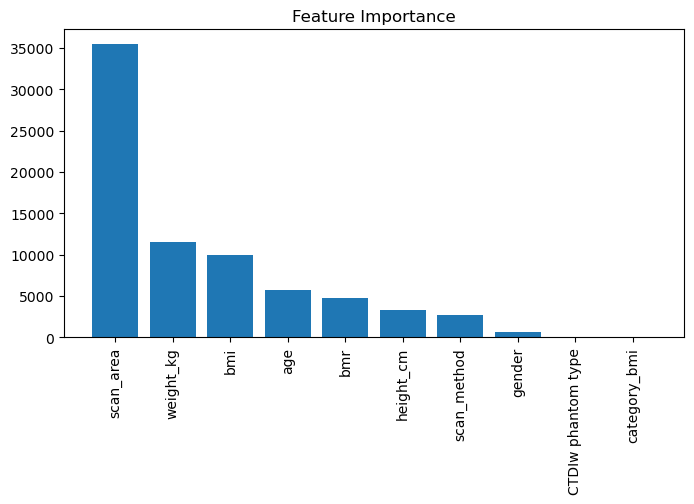

In [19]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain')
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.title('Feature Importance')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.show()

### Permutation Feature Importance

In [63]:
pfi = PermutationFeatureImportance(model, X, y, X.columns, mean_absolute_percentage_error)

In [64]:
pfi.permutation_feature_importance(n_shuffle=20)

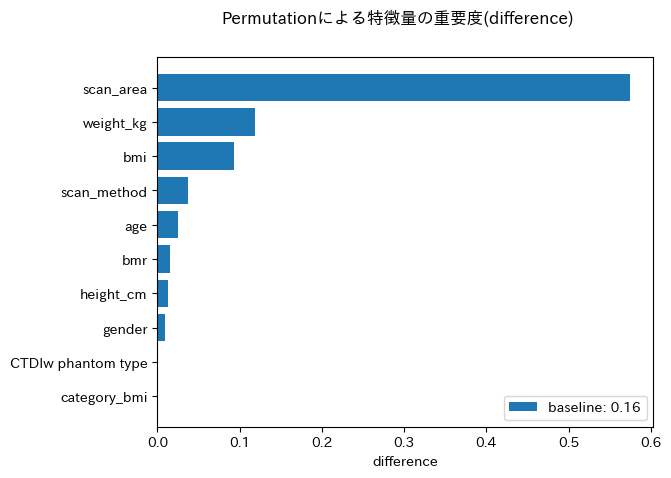

In [65]:
pfi.plot()

### Hyperparameter 

In [70]:
import optuna
from sklearn.model_selection import KFold

In [85]:
param_base = {
    'objective': 'mae',
    'random_seed': 42,
    'min_data_in_bin': 3,
    'bagging_freq': 1,
    'bagging_seed': 0,
    'verbose': -1,
}

def objective(trial):
    param_tuning = {
        'num_leaves': trial.suggest_int('num_leaves', 50, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 0.95),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.35, 0.65),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 1, log=True),
    }
    
    param_tuning.update(param_base)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
        X_tr = X.iloc[tr_idx]
        X_va = X.iloc[va_idx]
        y_tr = y.iloc[tr_idx]
        y_va = y.iloc[va_idx]
        
        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)
        
        model = lgb.train(param_tuning,
                          lgb_train,
                          num_boost_round=10000,
                          valid_sets=[lgb_train, lgb_eval],
                          valid_names=['train', 'valid'],
                          callbacks=[lgb.early_stopping(100),
                                     lgb.log_evaluation(500)])
        
    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print('')
    
    return score

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=200)

[I 2023-07-10 10:57:19,153] A new study created in memory with name: no-name-05056e54-028e-4235-9ee4-19fed031ee08


Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.58936	valid's l1: 2.84137
Early stopping, best iteration is:
[429]	train's l1: 1.6158	valid's l1: 2.8378
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	train's l1: 1.8049	valid's l1: 2.52619
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	train's l1: 1.83961	valid's l1: 2.50193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	train's l1: 1.77322	valid's l1: 2.47608
Training until validation scores don't improve for 100 rounds


[I 2023-07-10 10:57:25,826] Trial 0 finished with value: 2.9627247191458896 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'learning_rate': 0.12094991183825714, 'max_bin': 309, 'bagging_fraction': 0.8635482199008357, 'feature_fraction': 0.5437682339199968, 'min_gain_to_split': 0.07501954443620121, 'lambda_l1': 0.6074996073425692, 'lambda_l2': 0.8459126528049372}. Best is trial 0 with value: 2.9627247191458896.


Early stopping, best iteration is:
[156]	train's l1: 1.80223	valid's l1: 2.96272

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.7609	valid's l1: 2.98415
Early stopping, best iteration is:
[427]	train's l1: 1.78948	valid's l1: 2.98222
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.82216	valid's l1: 2.6167
[1000]	train's l1: 1.68759	valid's l1: 2.60631
Early stopping, best iteration is:
[913]	train's l1: 1.70421	valid's l1: 2.60497
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.82079	valid's l1: 2.58288
Early stopping, best iteration is:
[841]	train's l1: 1.72396	valid's l1: 2.57211
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.82835	valid's l1: 2.58183
Early stopping, best iteration is:
[646]	train's l1: 1.77242	valid's l1: 2.57579
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.72397	valid's l1: 3.03217
Early sto

[I 2023-07-10 10:57:39,919] Trial 1 finished with value: 3.027824926906157 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 24, 'learning_rate': 0.106250089030828, 'max_bin': 314, 'bagging_fraction': 0.9388394957438991, 'feature_fraction': 0.37131081745936606, 'min_gain_to_split': 0.014936835544198456, 'lambda_l1': 0.01097581541938016, 'lambda_l2': 0.46263628414755864}. Best is trial 0 with value: 2.9627247191458896.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	train's l1: 1.83192	valid's l1: 2.86548
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	train's l1: 1.74374	valid's l1: 2.56412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	train's l1: 1.8195	valid's l1: 2.49406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l1: 2.03495	valid's l1: 2.53637
Training until validation scores don't improve for 100 rounds


[I 2023-07-10 10:57:46,529] Trial 2 finished with value: 2.9988185975602324 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 27, 'learning_rate': 0.19574505010432006, 'max_bin': 360, 'bagging_fraction': 0.8692219043379398, 'feature_fraction': 0.5841587528859367, 'min_gain_to_split': 0.017240460099242298, 'lambda_l1': 0.19047678084282033, 'lambda_l2': 0.01935114088559527}. Best is trial 0 with value: 2.9627247191458896.


Early stopping, best iteration is:
[72]	train's l1: 1.85299	valid's l1: 2.99882

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	train's l1: 1.60574	valid's l1: 2.84396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[384]	train's l1: 1.59675	valid's l1: 2.5313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	train's l1: 1.70024	valid's l1: 2.50058
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	train's l1: 1.76461	valid's l1: 2.48618
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	train's l1: 1.68693	valid's l1: 2.98501


[I 2023-07-10 10:58:01,536] Trial 3 finished with value: 2.9850055182784536 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 17, 'learning_rate': 0.0835177260581142, 'max_bin': 253, 'bagging_fraction': 0.9161350534151325, 'feature_fraction': 0.4868450996649646, 'min_gain_to_split': 0.13704648392849017, 'lambda_l1': 0.010903843281968528, 'lambda_l2': 0.1718980674331938}. Best is trial 0 with value: 2.9627247191458896.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	train's l1: 1.82135	valid's l1: 2.90384
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[159]	train's l1: 1.74026	valid's l1: 2.61065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	train's l1: 1.61366	valid's l1: 2.59791
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	train's l1: 1.80306	valid's l1: 2.53782
Training until validation scores don't improve for 100 rounds


[I 2023-07-10 10:58:09,593] Trial 4 finished with value: 3.0373980447723876 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 19, 'learning_rate': 0.1888058676244102, 'max_bin': 337, 'bagging_fraction': 0.8539261850860679, 'feature_fraction': 0.4811095861398024, 'min_gain_to_split': 0.2484633816898239, 'lambda_l1': 0.0131962624184222, 'lambda_l2': 0.21554275565447506}. Best is trial 0 with value: 2.9627247191458896.


Early stopping, best iteration is:
[271]	train's l1: 1.53834	valid's l1: 3.0374

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.61684	valid's l1: 2.8027
Early stopping, best iteration is:
[619]	train's l1: 1.54233	valid's l1: 2.79635
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.69423	valid's l1: 2.45982
Early stopping, best iteration is:
[582]	train's l1: 1.63978	valid's l1: 2.45326
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.67995	valid's l1: 2.45999
Early stopping, best iteration is:
[622]	train's l1: 1.60117	valid's l1: 2.45431
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.69649	valid's l1: 2.43827
Early stopping, best iteration is:
[551]	train's l1: 1.65867	valid's l1: 2.43645
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.56988	valid's l1: 2.92125
Early stopping, best iteration is:
[415]	train's l1: 1.6

[I 2023-07-10 10:58:26,923] Trial 5 finished with value: 2.918035092969341 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 8, 'learning_rate': 0.02665633323331581, 'max_bin': 263, 'bagging_fraction': 0.8545566156413934, 'feature_fraction': 0.5210590311253639, 'min_gain_to_split': 0.07537078298264387, 'lambda_l1': 0.9478675948634673, 'lambda_l2': 0.015998881492631498}. Best is trial 5 with value: 2.918035092969341.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.44954	valid's l1: 2.95558
Early stopping, best iteration is:
[434]	train's l1: 1.49059	valid's l1: 2.94477
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.50736	valid's l1: 2.63506
Early stopping, best iteration is:
[428]	train's l1: 1.55578	valid's l1: 2.62451
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[287]	train's l1: 1.68385	valid's l1: 2.56841
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.50845	valid's l1: 2.61798
Early stopping, best iteration is:
[475]	train's l1: 1.52739	valid's l1: 2.61337
Training until validation scores don't improve for 100 rounds


[I 2023-07-10 10:58:35,249] Trial 6 finished with value: 3.05246051844517 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 6, 'learning_rate': 0.1309685567676143, 'max_bin': 250, 'bagging_fraction': 0.8699466159284459, 'feature_fraction': 0.42332767760048085, 'min_gain_to_split': 0.020794053992139315, 'lambda_l1': 0.016624564693643644, 'lambda_l2': 0.20542778286285945}. Best is trial 5 with value: 2.918035092969341.


Early stopping, best iteration is:
[178]	train's l1: 1.78563	valid's l1: 3.05246

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	train's l1: 1.85818	valid's l1: 2.7588
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	train's l1: 1.77454	valid's l1: 2.42417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	train's l1: 1.69247	valid's l1: 2.43131
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	train's l1: 1.81066	valid's l1: 2.40484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	train's l1: 1.60861	valid's l1: 2.88524


[I 2023-07-10 10:58:44,136] Trial 7 finished with value: 2.8852366256741777 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 7, 'learning_rate': 0.07437630896153186, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'feature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_l1': 0.8972612866432508, 'lambda_l2': 0.08655704137361815}. Best is trial 7 with value: 2.8852366256741777.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.54307	valid's l1: 3.08124
Early stopping, best iteration is:
[588]	train's l1: 1.51047	valid's l1: 3.07533
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[307]	train's l1: 1.70107	valid's l1: 2.71457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	train's l1: 1.67633	valid's l1: 2.69943
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.60161	valid's l1: 2.72074
Early stopping, best iteration is:
[811]	train's l1: 1.5107	valid's l1: 2.71129
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.52479	valid's l1: 3.16647
Early stopping, best iteration is:
[463]	train's l1: 1.5405	valid's l1: 3.16254


[I 2023-07-10 10:59:08,463] Trial 8 finished with value: 3.1625447407894485 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'learning_rate': 0.14811345230026204, 'max_bin': 207, 'bagging_fraction': 0.8424210443864615, 'feature_fraction': 0.38605896836395065, 'min_gain_to_split': 0.0391093317225106, 'lambda_l1': 0.0172764870082179, 'lambda_l2': 0.04324803290528771}. Best is trial 7 with value: 2.8852366256741777.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	train's l1: 1.94344	valid's l1: 2.90087
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	train's l1: 1.34575	valid's l1: 2.48227
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	train's l1: 1.77471	valid's l1: 2.53732
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's l1: 1.41387	valid's l1: 2.51464
Training until validation scores don't improve for 100 rounds


[I 2023-07-10 10:59:14,816] Trial 9 finished with value: 2.9259158074956626 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 3, 'learning_rate': 0.13880195175463395, 'max_bin': 313, 'bagging_fraction': 0.8398084236409168, 'feature_fraction': 0.5069744160400099, 'min_gain_to_split': 0.015412781495004139, 'lambda_l1': 0.14187079131473238, 'lambda_l2': 0.7220917699605239}. Best is trial 7 with value: 2.8852366256741777.


Early stopping, best iteration is:
[85]	train's l1: 1.65147	valid's l1: 2.92592

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.80755	valid's l1: 2.75364
Early stopping, best iteration is:
[500]	train's l1: 1.80755	valid's l1: 2.75364
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.86508	valid's l1: 2.42404
Early stopping, best iteration is:
[542]	train's l1: 1.8403	valid's l1: 2.42274
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	train's l1: 1.92358	valid's l1: 2.41662
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.87086	valid's l1: 2.4091
Early stopping, best iteration is:
[644]	train's l1: 1.79766	valid's l1: 2.40205
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[353]	train's l1: 1.84785	valid's l1: 2.87909


[I 2023-07-10 10:59:24,876] Trial 10 finished with value: 2.8790902608039053 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'learning_rate': 0.0601274251181819, 'max_bin': 386, 'bagging_fraction': 0.8041584039871953, 'feature_fraction': 0.6465177168990522, 'min_gain_to_split': 0.5088357362443391, 'lambda_l1': 0.4204551476528378, 'lambda_l2': 0.06695233513296726}. Best is trial 10 with value: 2.8790902608039053.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	train's l1: 1.94887	valid's l1: 2.77097
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.95798	valid's l1: 2.43578
Early stopping, best iteration is:
[445]	train's l1: 1.97745	valid's l1: 2.43371
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.95633	valid's l1: 2.42619
Early stopping, best iteration is:
[632]	train's l1: 1.90139	valid's l1: 2.42082
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.96027	valid's l1: 2.40634
Early stopping, best iteration is:
[638]	train's l1: 1.90059	valid's l1: 2.40253
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.84399	valid's l1: 2.88745
Early stopping, best iteration is:
[662]	train's l1: 1.78482	valid's l1: 2.87653


[I 2023-07-10 10:59:34,241] Trial 11 finished with value: 2.876990800307805 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 11, 'learning_rate': 0.055111044566937564, 'max_bin': 400, 'bagging_fraction': 0.8052703597789115, 'feature_fraction': 0.6359548336404655, 'min_gain_to_split': 0.9080547161828647, 'lambda_l1': 0.42758222144640173, 'lambda_l2': 0.06592947228824622}. Best is trial 11 with value: 2.876990800307805.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.91083	valid's l1: 2.76556
Early stopping, best iteration is:
[722]	train's l1: 1.81709	valid's l1: 2.76134
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.98164	valid's l1: 2.42631
Early stopping, best iteration is:
[496]	train's l1: 1.98384	valid's l1: 2.42589
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.97698	valid's l1: 2.42573
Early stopping, best iteration is:
[731]	train's l1: 1.8803	valid's l1: 2.41678
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.97258	valid's l1: 2.41699
Early stopping, best iteration is:
[552]	train's l1: 1.94748	valid's l1: 2.4133
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.87046	valid's l1: 2.88229
Early stopping, best iteration is:
[750]	train's l1: 1.77503	valid's l1: 2.86827


[I 2023-07-10 10:59:45,861] Trial 12 finished with value: 2.868270874573443 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 12, 'learning_rate': 0.0480683492427996, 'max_bin': 394, 'bagging_fraction': 0.8008768726685604, 'feature_fraction': 0.6421506363915696, 'min_gain_to_split': 0.8724846927673231, 'lambda_l1': 0.35534274321780757, 'lambda_l2': 0.0508212914971081}. Best is trial 12 with value: 2.868270874573443.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.42028	valid's l1: 2.90748
[1000]	train's l1: 2.19339	valid's l1: 2.789
[1500]	train's l1: 2.09673	valid's l1: 2.76394
[2000]	train's l1: 2.03341	valid's l1: 2.75419
[2500]	train's l1: 1.99204	valid's l1: 2.74913
Early stopping, best iteration is:
[2740]	train's l1: 1.96547	valid's l1: 2.74273
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.49818	valid's l1: 2.54661
[1000]	train's l1: 2.26497	valid's l1: 2.4582
[1500]	train's l1: 2.16348	valid's l1: 2.439
[2000]	train's l1: 2.10655	valid's l1: 2.432
[2500]	train's l1: 2.06153	valid's l1: 2.42819
[3000]	train's l1: 2.02609	valid's l1: 2.42575
Early stopping, best iteration is:
[3273]	train's l1: 2.01027	valid's l1: 2.42462
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.4874	valid's l1: 2.55709
[1000]	train's l1: 2.26854	valid's l1: 2.46016
[1500]	train's l1: 2.16594	valid's l1: 2.43179
[2

[I 2023-07-10 11:00:39,795] Trial 13 finished with value: 2.875216597496461 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 13, 'learning_rate': 0.008460647520158494, 'max_bin': 398, 'bagging_fraction': 0.8035365780202304, 'feature_fraction': 0.6431895571891458, 'min_gain_to_split': 0.9832973331640446, 'lambda_l1': 0.2997703129905734, 'lambda_l2': 0.03862762106944497}. Best is trial 12 with value: 2.868270874573443.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.42812	valid's l1: 2.99828
[1000]	train's l1: 2.09161	valid's l1: 2.78447
[1500]	train's l1: 1.98666	valid's l1: 2.75358
[2000]	train's l1: 1.93471	valid's l1: 2.74431
[2500]	train's l1: 1.90333	valid's l1: 2.74026
[3000]	train's l1: 1.87849	valid's l1: 2.7374
[3500]	train's l1: 1.85307	valid's l1: 2.73511
Early stopping, best iteration is:
[3525]	train's l1: 1.85156	valid's l1: 2.73499
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.49694	valid's l1: 2.61921
[1000]	train's l1: 2.16807	valid's l1: 2.47682
[1500]	train's l1: 2.06219	valid's l1: 2.4534
[2000]	train's l1: 2.0061	valid's l1: 2.44851
[2500]	train's l1: 1.9637	valid's l1: 2.44348
[3000]	train's l1: 1.92945	valid's l1: 2.43947
[3500]	train's l1: 1.90019	valid's l1: 2.43752
[4000]	train's l1: 1.87945	valid's l1: 2.43542
Early stopping, best iteration is:
[4190]	train's l1: 1.87203	valid's l1: 2.4349
Training unti

[I 2023-07-10 11:02:04,258] Trial 14 finished with value: 2.8975603731938646 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 14, 'learning_rate': 0.006683245874362568, 'max_bin': 367, 'bagging_fraction': 0.8254600338777949, 'feature_fraction': 0.5970156489637081, 'min_gain_to_split': 0.9330241489723684, 'lambda_l1': 0.24929512772816564, 'lambda_l2': 0.030978529243905865}. Best is trial 12 with value: 2.868270874573443.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.87509	valid's l1: 3.38357
[1000]	train's l1: 2.30992	valid's l1: 2.88082
[1500]	train's l1: 2.14733	valid's l1: 2.79941
[2000]	train's l1: 2.05279	valid's l1: 2.7676
[2500]	train's l1: 1.98302	valid's l1: 2.75295
[3000]	train's l1: 1.92725	valid's l1: 2.746
[3500]	train's l1: 1.8718	valid's l1: 2.73849
Early stopping, best iteration is:
[3825]	train's l1: 1.84383	valid's l1: 2.73687
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.96076	valid's l1: 2.93153
[1000]	train's l1: 2.38236	valid's l1: 2.53617
[1500]	train's l1: 2.22139	valid's l1: 2.47312
[2000]	train's l1: 2.12247	valid's l1: 2.445
[2500]	train's l1: 2.04848	valid's l1: 2.43464
[3000]	train's l1: 1.99314	valid's l1: 2.4282
Early stopping, best iteration is:
[3221]	train's l1: 1.97066	valid's l1: 2.42531
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.94012	valid's l1: 2.92191
[

[I 2023-07-10 11:03:16,674] Trial 15 finished with value: 2.8874473601527173 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 13, 'learning_rate': 0.004378765791308886, 'max_bin': 400, 'bagging_fraction': 0.8239083873765469, 'feature_fraction': 0.6411377719733294, 'min_gain_to_split': 0.42692351451920874, 'lambda_l1': 0.08439999106912553, 'lambda_l2': 0.03258581897457414}. Best is trial 12 with value: 2.868270874573443.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.98551	valid's l1: 2.76137
[1000]	train's l1: 1.82504	valid's l1: 2.75024
Early stopping, best iteration is:
[1007]	train's l1: 1.82364	valid's l1: 2.74984
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.07546	valid's l1: 2.44258
Early stopping, best iteration is:
[495]	train's l1: 2.07826	valid's l1: 2.44242
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.08114	valid's l1: 2.44394
Early stopping, best iteration is:
[525]	train's l1: 2.06894	valid's l1: 2.44097
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.07869	valid's l1: 2.43278
[1000]	train's l1: 1.89361	valid's l1: 2.42013
Early stopping, best iteration is:
[1314]	train's l1: 1.81948	valid's l1: 2.41288
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.97223	valid's l1: 2.90505
Early stopping, best iteration is:
[665

[I 2023-07-10 11:03:28,849] Trial 16 finished with value: 2.898182321978061 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 15, 'learning_rate': 0.03601069374176358, 'max_bin': 343, 'bagging_fraction': 0.8028818357424261, 'feature_fraction': 0.5573378861599921, 'min_gain_to_split': 0.5013234521000254, 'lambda_l1': 0.3166617964479014, 'lambda_l2': 0.013354483409687073}. Best is trial 12 with value: 2.868270874573443.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.14149	valid's l1: 2.82617
[1000]	train's l1: 2.07917	valid's l1: 2.81821
Early stopping, best iteration is:
[1018]	train's l1: 2.07775	valid's l1: 2.81761
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.21823	valid's l1: 2.48606
Early stopping, best iteration is:
[583]	train's l1: 2.20565	valid's l1: 2.48318
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.24256	valid's l1: 2.4727
Early stopping, best iteration is:
[767]	train's l1: 2.2012	valid's l1: 2.46787
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.22726	valid's l1: 2.51651
[1000]	train's l1: 2.17661	valid's l1: 2.5061
Early stopping, best iteration is:
[1005]	train's l1: 2.17603	valid's l1: 2.50582
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.12918	valid's l1: 2.94537
[1000]	train's l1: 2.07526	valid's l1: 2.9

[I 2023-07-10 11:03:39,561] Trial 17 finished with value: 2.932904201139202 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 30, 'learning_rate': 0.03243811710491679, 'max_bin': 286, 'bagging_fraction': 0.8337876493312537, 'feature_fraction': 0.614194606032441, 'min_gain_to_split': 0.9624687936531181, 'lambda_l1': 0.0989592432819218, 'lambda_l2': 0.010198127712737249}. Best is trial 12 with value: 2.868270874573443.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 3.92752	valid's l1: 4.41278
[1000]	train's l1: 2.84791	valid's l1: 3.37448
[1500]	train's l1: 2.45131	valid's l1: 3.00311
[2000]	train's l1: 2.27403	valid's l1: 2.86963
[2500]	train's l1: 2.16648	valid's l1: 2.81208
[3000]	train's l1: 2.07095	valid's l1: 2.77506
[3500]	train's l1: 1.98911	valid's l1: 2.74735
[4000]	train's l1: 1.92058	valid's l1: 2.72945
[4500]	train's l1: 1.86197	valid's l1: 2.7192
[5000]	train's l1: 1.8137	valid's l1: 2.71015
[5500]	train's l1: 1.76498	valid's l1: 2.70171
[6000]	train's l1: 1.71765	valid's l1: 2.69811
[6500]	train's l1: 1.66879	valid's l1: 2.69236
Early stopping, best iteration is:
[6635]	train's l1: 1.6566	valid's l1: 2.692
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 4.03617	valid's l1: 3.89034
[1000]	train's l1: 2.93596	valid's l1: 2.91063


In [ ]:
# 最適化の結果確認
trial = study.best_trial
print(f'trial {trial.number}')
print(f'MAE best: {trial.value}')
display(trial.params)